In [60]:
import xarray as xr
import datetime
import pymannkendall as mk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import theilslopes
from dask.diagnostics import ProgressBar
import pymannkendall as mk

In [ ]:
# I can compare to MODIS data MODIS LST max ! -> MODIS terra

In [2]:
# read per year and then concact!
lst_2007 = xr.open_mfdataset('/mnt/data7/nfs4/avh_lst/sdupuis/EUSTACE/All_Arctic/2007/AVMEA/LST_AVMEA_All_Arctic__v.11.0__*DAY.nc', engine='netcdf4')

In [3]:
# read per year and then concact!
lst_2008 = xr.open_mfdataset('/mnt/data7/nfs4/avh_lst/sdupuis/EUSTACE/All_Arctic/2008/AVMEA/LST_AVMEA_All_Arctic__v.11.0__*DAY.nc', engine='netcdf4')

In [4]:
lst_2009 = xr.open_mfdataset('/mnt/data7/nfs4/avh_lst/sdupuis/EUSTACE/All_Arctic/2009/AVMEA/LST_AVMEA_All_Arctic__v.11.0__*DAY.nc', engine='netcdf4')

In [5]:
lst_2010 = xr.open_mfdataset('/mnt/data7/nfs4/avh_lst/sdupuis/EUSTACE/All_Arctic/2010/AVMEA/LST_AVMEA_All_Arctic__v.11.0__*DAY.nc', engine='netcdf4')

In [6]:
lst_2011 = xr.open_mfdataset('/mnt/data7/nfs4/avh_lst/sdupuis/EUSTACE/All_Arctic/2011/AVMEA/LST_AVMEA_All_Arctic__v.11.0__*DAY.nc', engine='netcdf4')

In [7]:
lst_2012 = xr.open_mfdataset('/mnt/data7/nfs4/avh_lst/sdupuis/EUSTACE/All_Arctic/2012/AVMEA/LST_AVMEA_All_Arctic__v.11.0__*DAY.nc', engine='netcdf4')

In [8]:
lst_2013 = xr.open_mfdataset('/mnt/data7/nfs4/avh_lst/sdupuis/EUSTACE/All_Arctic/2013/AVMEA/LST_AVMEA_All_Arctic__v.11.0__*DAY.nc', engine='netcdf4')

In [9]:
lst_2014 = xr.open_mfdataset('/mnt/data7/nfs4/avh_lst/sdupuis/EUSTACE/All_Arctic/2014/AVMEA/LST_AVMEA_All_Arctic__v.11.0__*DAY.nc', engine='netcdf4')

In [10]:
lst_2015 = xr.open_mfdataset('/mnt/data7/nfs4/avh_lst/sdupuis/EUSTACE/All_Arctic/2015/AVMEA/LST_AVMEA_All_Arctic__v.11.0__*DAY.nc', engine='netcdf4')

In [11]:
lst_2016 = xr.open_mfdataset('/mnt/data7/nfs4/avh_lst/sdupuis/EUSTACE/All_Arctic/2016/AVMEB/LST_AVMEB_All_Arctic__v.11.0__*DAY.nc', engine='netcdf4')

In [12]:
lst_2017 = xr.open_mfdataset('/mnt/data7/nfs4/avh_lst/sdupuis/EUSTACE/All_Arctic/2017/AVMEB/LST_AVMEB_All_Arctic__v.11.0__*DAY.nc', engine='netcdf4')

In [13]:
lst_2018 = xr.open_mfdataset('/mnt/data7/nfs4/avh_lst/sdupuis/EUSTACE/All_Arctic/2018/AVMEB/LST_AVMEB_All_Arctic__v.11.0__*DAY.nc', engine='netcdf4')

In [14]:
lst_2019 = xr.open_mfdataset('/mnt/data7/nfs4/avh_lst/sdupuis/EUSTACE/All_Arctic/2019/AVMEB/LST_AVMEB_All_Arctic__v.11.0__*DAY.nc', engine='netcdf4')

In [15]:
lst_2020 = xr.open_mfdataset('/mnt/data7/nfs4/avh_lst/sdupuis/EUSTACE/All_Arctic/2020/AVMEB/LST_AVMEB_All_Arctic__v.11.0__*DAY.nc', engine='netcdf4')

In [16]:
lst_2021 = xr.open_mfdataset('/mnt/data7/nfs4/avh_lst/sdupuis/EUSTACE/All_Arctic/2021/AVMEB/LST_AVMEB_All_Arctic__v.11.0__*DAY.nc', engine='netcdf4')

In [17]:
lst_2022 = xr.open_mfdataset('/mnt/data7/nfs4/avh_lst/sdupuis/EUSTACE/All_Arctic/2022/AVMEB/LST_AVMEB_All_Arctic__v.11.0__*DAY.nc', engine='netcdf4')

In [18]:
lst_2023 = xr.open_mfdataset('/mnt/data7/nfs4/avh_lst/sdupuis/EUSTACE/All_Arctic/2023/AVMEB/LST_AVMEB_All_Arctic__v.11.0__*DAY.nc', engine='netcdf4')

In [19]:
land_cover = xr.open_dataset('/mnt/data7/nfs4/avh_ndvi/sdupuis/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7b.nc', engine='netcdf4')
lc = land_cover.sel(lat=slice(72,55), lon=slice(-168,-150))

In [20]:
lc_interp = lc.interp(lat=lst_2023.coords['lat'], lon=lst_2023.coords['lon'], method='nearest')

In [59]:
def semimonth_time(time):
    year = time.dt.year
    month = time.dt.month

    day = xr.where(time.dt.day <= 15, 1, 16)
    #print(day)

    ymd = year * 10000 + month * 100 + day

    return xr.apply_ufunc(
        pd.to_datetime,
        ymd,
        kwargs={"format": "%Y%m%d"},
        vectorize=True,
        output_dtypes=["datetime64[ns]"],
    )

In [61]:
results = []

for year in range(2007, 2024):

    ds = globals()[f"lst_{year}"]

    # --------------------------------------------------
    # 2. Mask unwanted landcover
    # --------------------------------------------------
    ds = ds.where(lc_interp['lccs_class'] != 210)

    # --------------------------------------------------
    # 3. Remove clouds (flag = 110)
    # --------------------------------------------------
    clean_LST = ds['LST'].where(ds['LST'] != 110)

    # --------------------------------------------------
    # 4. Create semi-monthly bins
    # --------------------------------------------------
    clean_LST = clean_LST.assign_coords(
        semimonth_time=semimonth_time(clean_LST.time)
    )

    # --------------------------------------------------
    # 5. Aggregate (MAX per semi-month)
    # --------------------------------------------------
    semi_month_max = (
        clean_LST
        .groupby("semimonth_time")
        .max()
        .rename({"semimonth_time": "time"})
    )

    results.append(semi_month_max)

/tmp/ipykernel_14448/766118834.py:10: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  return xr.apply_ufunc(
/tmp/ipykernel_14448/766118834.py:10: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead 

In [62]:
lst_semimonth = xr.concat(results, dim="time").sortby("time")

In [63]:
print(semi_month_max.time[1:8].values)

['2023-01-16T00:00:00.000000000' '2023-02-01T00:00:00.000000000'
 '2023-02-16T00:00:00.000000000' '2023-03-01T00:00:00.000000000'
 '2023-03-16T00:00:00.000000000' '2023-04-01T00:00:00.000000000'
 '2023-04-16T00:00:00.000000000']


In [23]:
# load the time series somewhere ?
# try as monthly max

results = {}

for year in range(2007, 2024):

    ds = globals()[f"lst_{year}"]   # load lst_1981, lst_1982, ...

    # 2. Fixed 10-day bins anchored at Jan 1 every year
    
    ds = ds.where(lc_interp['lccs_class'] != 210)
    print(ds)
    clean_LST = ds['LST'].where(ds['LST'] != 110, np.nan)
    max_mon = (
        clean_LST
        .resample(
            time='1MS'
        )
        .max()
    )

    # Ensure bins exist even with no data
    # Xarray automatically creates them and fills with NaN

    results[year] = max_mon

<xarray.Dataset>
Dimensions:      (lat: 800, lon: 7200, time: 213)
Coordinates:
  * lat          (lat) float32 50.03 50.08 50.12 50.17 ... 89.88 89.93 89.97
  * lon          (lon) float32 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
    band         int64 1
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2007-06-02 2007-06-03 ... 2007-12-31
Data variables:
    LST          (lat, lon, time) float32 dask.array<chunksize=(800, 7200, 1), meta=np.ndarray>
    satzen       (time, lat, lon) float32 dask.array<chunksize=(1, 800, 7200), meta=np.ndarray>
    sunzen       (time, lat, lon) float32 dask.array<chunksize=(1, 800, 7200), meta=np.ndarray>
    scan_time    (time, lat, lon) float32 dask.array<chunksize=(1, 800, 7200), meta=np.ndarray>
    test_mae     (time, lat, lon) float32 dask.array<chunksize=(1, 800, 7200), meta=np.ndarray>
    r2           (time, lat, lon) float32 dask.array<chunksize=(1, 800, 7200), meta=np.ndarray>
<xarray.Dataset>
Dimensions:      (lat: 800,

In [24]:
combined = xr.concat([results[y] for y in range(2007, 2024)], dim="time")

In [29]:
combined

<xarray.DataArray 'LST' (lat: 800, lon: 7200, time: 199)>
dask.array<concatenate, shape=(800, 7200, 199), dtype=float32, chunksize=(800, 7200, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float32 50.03 50.08 50.12 50.17 ... 89.88 89.93 89.97
  * lon          (lon) float32 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
    band         int64 1
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2007-06-01 2007-07-01 ... 2023-12-01
    bin          (time) int64 6 7 8 9 10 11 12 1 2 3 ... 3 4 5 6 7 8 9 10 11 12

In [ ]:
bin_index = combined.time.dt.month
combined = combined.assign_coords(bin=bin_index)

/local/sdupuis/software/conda/envs/rioxarray_env/lib/python3.11/site-packages/dask/array/reductions.py:649: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


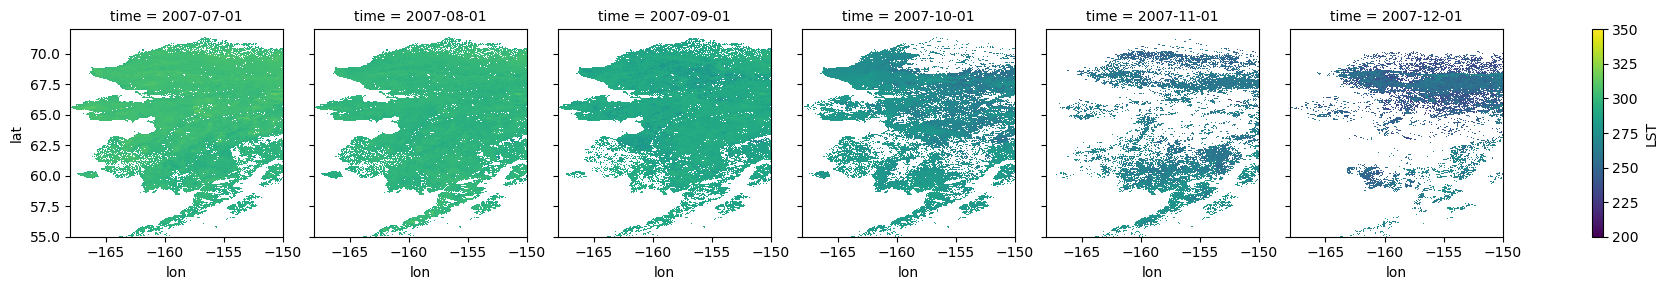

In [30]:
combined.sel(lat=slice(55,72), lon=slice(-168,-150), time=slice('2007-07','2007-12')).plot(x="lon", y="lat", col="time", col_wrap=6, vmax=350, vmin=200);

In [31]:
climatology = combined.groupby("bin").mean("time")

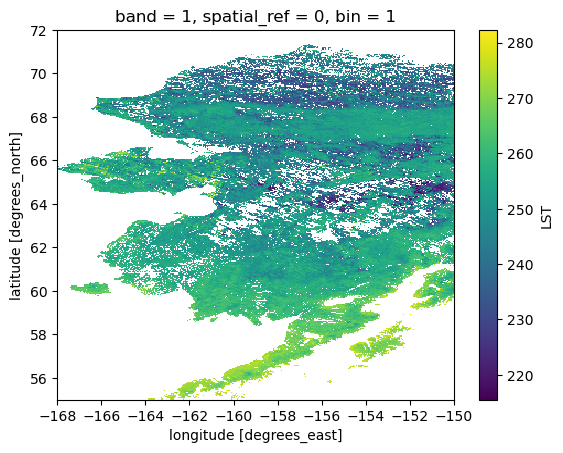

In [32]:
climatology.sel(lat=slice(55,72), lon=slice(-168,-150)).isel(bin=0).plot();

In [ ]:
# there are more clouds in the morning ? more cloudy than mean for NOAA ? blue spots in the middle ? 

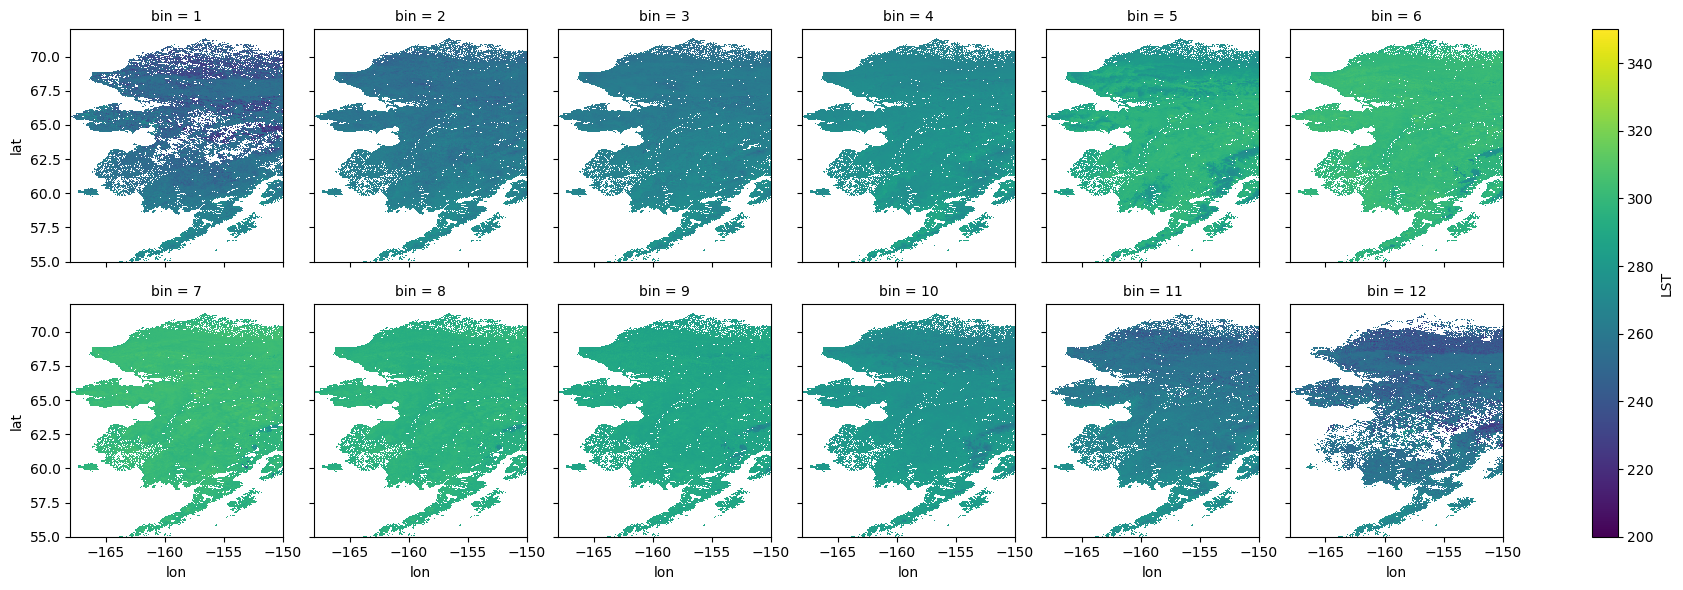

In [33]:
climatology.sel(lat=slice(55,72), lon=slice(-168,-150)).plot(x="lon", y="lat", col="bin", col_wrap=6, vmax=350, vmin=200);

In [34]:
anomalies = combined.groupby("bin") - climatology

/local/sdupuis/software/conda/envs/rioxarray_env/lib/python3.11/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 17 times more chunks
  return self.array[key]


In [35]:
anomalies

<xarray.DataArray 'LST' (lat: 800, lon: 7200, time: 199)>
dask.array<sub, shape=(800, 7200, 199), dtype=float32, chunksize=(800, 7200, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float32 50.03 50.08 50.12 50.17 ... 89.88 89.93 89.97
  * lon          (lon) float32 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
    band         (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    spatial_ref  (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * time         (time) datetime64[ns] 2007-06-01 2007-07-01 ... 2023-12-01
    bin          (time) int64 6 7 8 9 10 11 12 1 2 3 ... 3 4 5 6 7 8 9 10 11 12

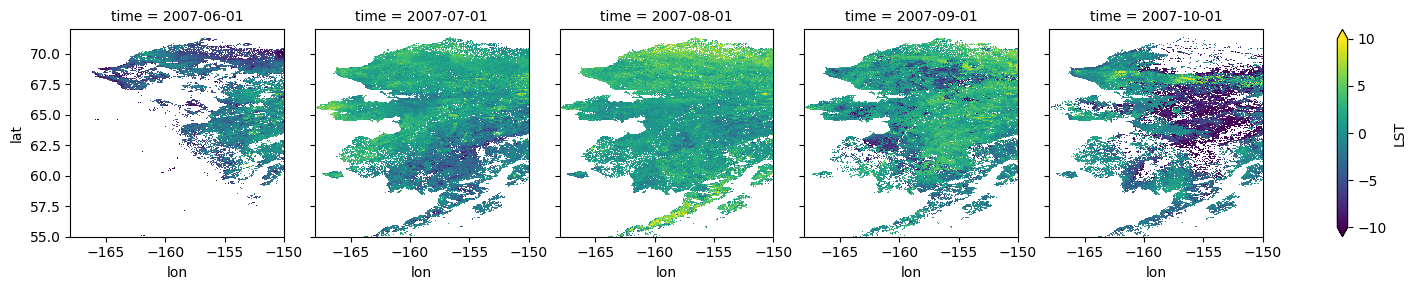

In [37]:
anomalies.sel(lat=slice(55,72), lon=slice(-168,-150), time=slice('2007-05','2007-10')).plot(x="lon", y="lat", col="time", col_wrap=5, vmin=-10, vmax=10);
plt.savefig('anomalies_metop.png')

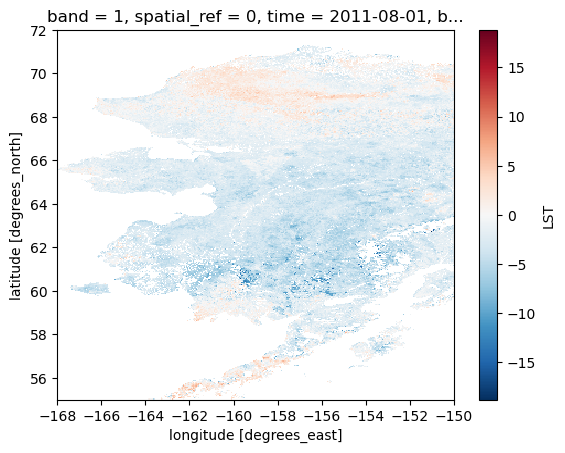

In [45]:
anomalies.sel(lat=slice(55,72), lon=slice(-168,-150)).isel(time=50).plot();

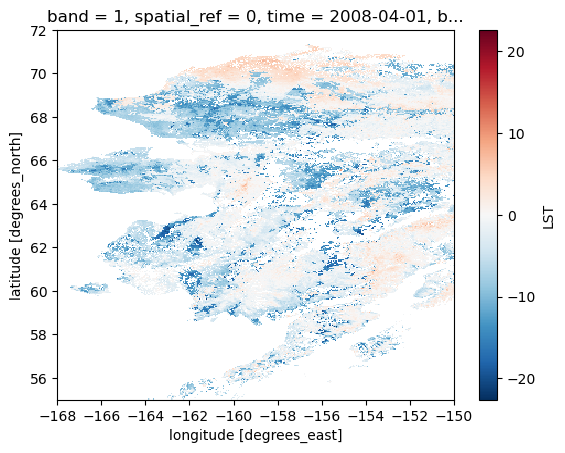

In [39]:
anomalies.sel(lat=slice(55,72), lon=slice(-168,-150)).isel(time=10).plot();

In [40]:
anoms = anomalies.sel(lat=slice(55,72), lon=slice(-168,-150))
anoms = anoms.chunk(dict(time=-1))   # <<< REQUIRED

In [43]:
time_frac = (
    anoms.time.dt.year
    + (anoms.time.dt.month - 0.5) / 12.0
)


In [42]:
def theil_sen_1d(y, x):
    # remove NaNs
    mask = np.isfinite(y) & np.isfinite(x)
    
    # not enough data points → return NaN
    if mask.sum() < 5:
        return np.nan
    
    slope, intercept, lower, upper = theilslopes(y[mask], x[mask])
    return slope

In [44]:
def theil_sen_1d_inter(y, x):
    # remove NaNs
    mask = np.isfinite(y) & np.isfinite(x)
    
    # not enough data points → return NaN
    if mask.sum() < 5:
        return np.nan
    
    slope, intercept, lower, upper = theilslopes(y[mask], x[mask])
    return intercept

In [46]:
slope = xr.apply_ufunc(
    theil_sen_1d,
    anoms,
    time_frac,
    input_core_dims=[["time"], ["time"]],
    output_core_dims=[[]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float],
)

trend_per_decade = slope * 1

In [48]:
with ProgressBar():
    res = trend_per_decade.compute()

[########################################] | 100% Completed | 15m 34s


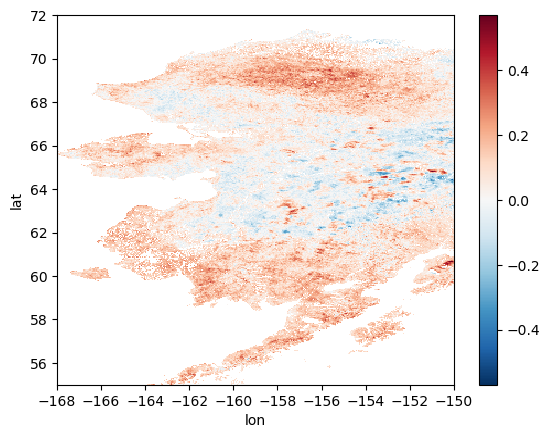

In [49]:
res.plot();

In [51]:
def mk_pvalue(y):
    y = y[np.isfinite(y)]
    if y.size < 5:
        return np.nan
    return mk.original_test(y).p

In [52]:
def mk_pvalue_slope(y):
    y = y[np.isfinite(y)]
    if y.size < 5:
        return np.nan
    return mk.original_test(y).slope

In [54]:
mk_p = xr.apply_ufunc(
    mk_pvalue,
    anoms,
    input_core_dims=[["time"]],
    output_core_dims=[[]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float],
)

In [55]:
with ProgressBar():
    p_val = mk_p.compute()

[########################################] | 100% Completed | 19m 32s


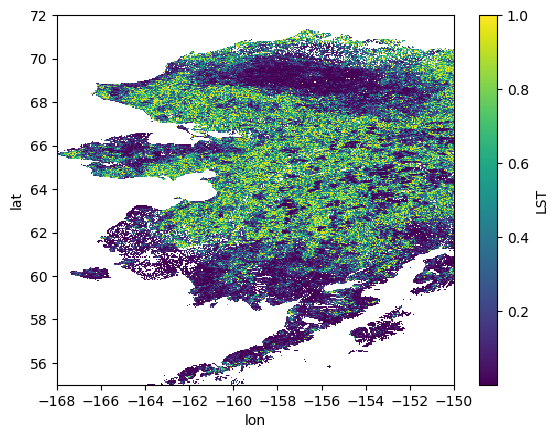

In [56]:
p_val.plot();

In [ ]:
# maximum temps more for a season than a month ? otherwise only 10D composites

In [57]:
significant_trend = res.where(p_val < 0.05)

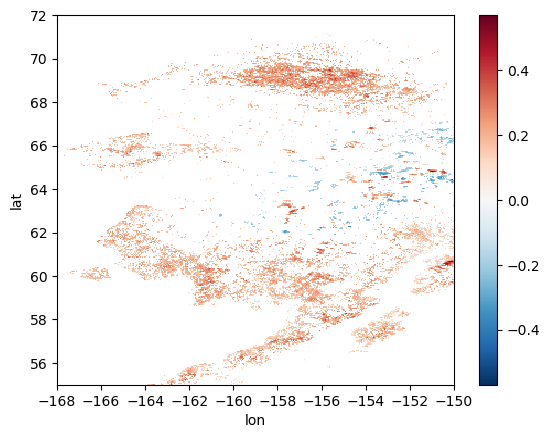

In [58]:
significant_trend.plot();